# Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# nltk packages
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
TRAIN_PATH = 'UtkMl_dataset/train.csv'
TEST_PATH = 'datasets/test.csv'

VOCAB_SIZE = 2500

## Read Data

INDEX, DOC_ID, WORD_ID, LABEL

In [3]:
sparse_train_data = np.loadtxt('trainning_data.txt', delimiter=' ', dtype=str)
sparse_test_data = np.loadtxt('test_data.txt', delimiter=' ', dtype=str)

'''grouped_data columns: DOC_ID, WORD_ID, LABEL, OCCURENCE indexed from vocab'''
grouped_data = np.loadtxt('grouped_data.txt', delimiter=' ', dtype=str)

In [4]:
data = pd.read_csv(TRAIN_PATH)
data

,Tweet,following,followers,actions,is_retweet,location,Type,Unnamed: 7
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,0.0,"Pennsylvania, USA",Quality,NaN
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,5001.0,0.0,"South Padre Island, Texas",Spam,NaN
2,Haven't been following the news but I understa...,0.0,0.0,NaN,0.0,Will never be broke ever again,Quality,NaN
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,0.0,Mundo,Quality,NaN
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,NaN,0.0,"Nottingham, England",Quality,NaN
...,...,...,...,...,...,...,...,...
14894,"#AllWentWrongWhen I told my hair stylist to ""g...",695.0,533.0,868.0,1.0,United States,Spam,NaN
14895,"They don't have to like you, and you don't hav...",0.0,0.0,0.0,0.0,NaN,Quality,NaN
14896,#Miami Graham Nash Live at Parker Playhouse #...,5647.0,15091.0,5823.0,0.0,United States,Spam,NaN
14897,@bethannhamilton is in the business of one-upp...,0.0,0.0,NaN,0.0,"Southgate, MI",Quality,NaN


In [5]:
vocab = pd.read_csv('vocab.csv')
vocab

,WORD_ID,VOCAB_WORD
0,0,http
1,1,trump
2,2,news
3,3,get
4,4,new
...,...,...
2495,2495,moto
2496,2496,yell
2497,2497,butter
2498,2498,lack


## Functions for decisions

In [6]:
# Function that checks against followers vs followees

# Returns true if following zero people

# Returns the ratio of followers to following
def _percent_followers_following(row):
    return row.followers / row.following
    
# big enough ratio to satisfy min_percent
def min_percent_followers(row, min_percent=.7):
    if row.following == 0: return True
    return _percent_followers_following(row) > min_percent

# Enough followers
def enough_followers(row, minimum_followers=10):
    return row.followers > minimum_followers

# is retweet
def is_retweet(row)-> bool:
    return True if row.is_retweet else False
    

## Creating a decision trees (without using spam words as a feature)

In [7]:
''' 
Decision Tree -- 1

returns whether true (spam) or false (not spam)

Structure:

1. Enough Followers
2. Minimum Percent Followers

''' 

# Testing tree one
def tree1(row):
    
    # First check if enough followers
    if(not enough_followers(row)):
        return False
    
    if(not min_percent_followers(row)):
        return False
    
    return True
    
    # Then check if Ratio of followers to following is high enough

In [8]:
''' 
Decision Tree -- 2

returns whether true (spam) or false (not spam)

Structure:

1. Minimum Percent Followers
2. Enough Followers

''' 
def tree2(row):
     
    # First check if enough followers
    if(not enough_followers(row)):
        return False
    
    if(not min_percent_followers(row)):
        return False
    
    return True   

In [9]:
''' 
Decision Tree -- 3

returns whether true (spam) or false (not spam)

Structure:

     enough_followers
    /            \
is_retweet    is_retweet

''' 
def tree3(row):
     
    if min_percent_followers(row):
        return True if is_retweet(row) else False
    
    else:
        return True if is_retweet(row) else False


In [10]:
''' 
Decision Tree -- 4

returns whether true (spam) or false (not spam)

Structure:

           is_retweet
           /         \
 Enough_Followers  Enough_Followers
''' 

def tree4(row):
    # First check if enough followers
    if is_retweet(row):
        return True if enough_followers(row) else False
    else: # not enough follower
        return True if enough_followers(row) else False
        

In [11]:
''' 
Decision Tree -- 5

returns whether true (spam) or false (not spam)

Structure:

           is_retweet
           /         \
 Enough_Followers  minimum_percent_followers
''' 

def tree5(row):
    # First check if enough followers
    if is_retweet(row):
        return True if enough_followers(row) else False
    else: # not enough follower
        return True if min_percent_followers(row) else False
        

## Running our random forest to create a dataframe with results

In [12]:
''' Creating dataframe '''

columns = ['Tweet', 'Spam Count','Ham Count', 'Classification', 'Actual']
res_df = pd.DataFrame(columns=columns)
trees = [tree1, tree2, tree3, tree4, tree5]

ham_count = 0
spam_count = 0
res = []

# Indices
rowIdx = 0
spamIdx = 1
hamIdx = 2
classificationIdx = 3

for i, sample in enumerate(range(data.shape[0])):
    # [tweetId, spam, ham, Final Classification]
    sample_results = [data.iloc[i][0], 0, 0, "Uninitialized"]
    
    for tree in trees:
        if tree(data.iloc[sample]):
            sample_results[spamIdx] += 1  # spam++
        else:
            sample_results[hamIdx] += 1 # ham++
    
    # Final Classification
    if sample_results[spamIdx] > sample_results[hamIdx]:
        sample_results[classificationIdx] = 'Spam'
    else:
        sample_results[classificationIdx] = 'Ham'
    
    # appending sample results to dataframe
    sample_results.append('Spam' if data.iloc[i].Type == 'Spam' else 'Ham')
    
    # add to dataframe
    res_df.loc[len(res_df)] = sample_results

## Check results against actual data classificaitons

In [13]:
mismatches = 0
for i in range(res_df.shape[0]):
    if res_df.iloc[i].Classification != res_df.iloc[i].Actual:
        mismatches += 1
        
print('num mismatches:', mismatches)
print('total samples:', res_df.shape[0])
print('percent right:', 1 - mismatches/res_df.shape[0])

num mismatches: 3228
total samples: 14899
percent right: 0.7833411638364991


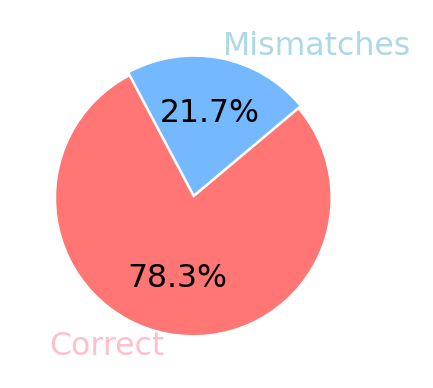

In [14]:
# Creating Pie Chart
category_names = ['Mismatches', 'Correct']
sizes = [mismatches, res_df.shape[0] - mismatches]
custom_colors = ['#74b9ff','#ff7675']

plt.figure(figsize=(2, 2), dpi=227)
wedges, labels, percents = plt.pie(sizes, labels=category_names, textprops={'fontsize': 10}, 
                                   startangle=40, autopct='%1.1f%%', colors=custom_colors, 
                                    explode=[0, 0.03])

# label colors
labels[0].set_color('lightblue')
labels[1].set_color('pink')
    
# display pie chart
plt.show()

# Let's Build Better Trees by using subsets of dataset!

In [15]:
four_samples = data.sample(4)

print(type(four_samples))
four_samples

<class 'pandas.core.frame.DataFrame'>


,Tweet,following,followers,actions,is_retweet,location,Type,Unnamed: 7
38,From Prisoner to Professor: Felon to Teach at ...,13879.0,32145.0,31719.0,0.0,160511,Spam,NaN
6309,Do you ever watch someones snap for the full 1...,0.0,0.0,13.0,0.0,First tweet: 10th March 2015,Quality,NaN
6579,Happy birthday dude!! @garrett_north81,0.0,0.0,NaN,0.0,"Columbus, OH",Quality,NaN
13374,"Movie bonding and 6 Pancit Cantons with Papa, ...",0.0,0.0,0.0,0.0,"Manila, Philippines",Quality,NaN


### Can we get the number of times a word appears in spam tweet?

then we can decide if the tweet is spam if more words are spam rather than not spam

Can we get the spam count of a word versus the ham count?

In [16]:
four_samples.index[0]

38

In [17]:
four_samples.iloc[0].Tweet

'From Prisoner to Professor: Felon to Teach at Georgetown Law https://t.co/Nth698CUPt https://t.co/x2zIZmPumn'

In [18]:
vocab = vocab.set_index('WORD_ID')
vocab

,VOCAB_WORD
WORD_ID,
0,http
1,trump
2,news
3,get
4,new
...,...
2495,moto
2496,yell
2497,butter


In [19]:
four_samples.iloc[0].Tweet

'From Prisoner to Professor: Felon to Teach at Georgetown Law https://t.co/Nth698CUPt https://t.co/x2zIZmPumn'

In [27]:
''' this is just to get the words from the sparse matrix by tweet_id '''

def get_sparse_rows(grouped_data, idx):
    res = []
    for row in grouped_data:
        if row[0] == str(idx):
            res.append([row])
            res[-1].append(vocab.iloc[int(row[1])][0])
    return res

In [30]:
get_sparse_rows(grouped_data, four_samples.index[0])

[[array(['38', '0', 'Spam', '2'], dtype='<U7'), 'http'],
 [array(['38', '215', 'Spam', '1'], dtype='<U7'), 'law'],
 [array(['38', '509', 'Spam', '1'], dtype='<U7'), 'prison'],
 [array(['38', '763', 'Spam', '1'], dtype='<U7'), 'teach'],
 [array(['38', '1715', 'Spam', '1'], dtype='<U7'), 'professor']]

## Loading text

In [50]:
ham_words_stemmed_freqs_list = np.loadtxt('ham_words_stemmed.txt', delimiter=' ', dtype=str)
spam_words_stemmed_freqs_list = np.loadtxt('spam_words_stemmed.txt', delimiter=' ', dtype=str)

# convert to dictionary
ham_words_stemmed_freqs = {}
for pair in ham_words_stemmed_freqs_list:
    ham_words_stemmed_freqs[pair[0]] = pair[1]

spam_words_stemmed_freqs = {}
for pair in spam_words_stemmed_freqs_list:
    spam_words_stemmed_freqs[pair[0]] = pair[1]   
    
spam_words_stemmed_freqs

{'http': '6195',
 'trump': '604',
 'news': '575',
 'rt': '334',
 'new': '252',
 'polic': '217',
 'man': '213',
 'get': '211',
 'sport': '208',
 'say': '205',
 'polit': '200',
 'peopl': '191',
 'break': '184',
 'obama': '178',
 'one': '165',
 'like': '164',
 'kill': '162',
 'world': '159',
 'amp': '157',
 'go': '156',
 'us': '149',
 'time': '145',
 'video': '144',
 'black': '143',
 'make': '143',
 'want': '138',
 'day': '136',
 'white': '133',
 'call': '132',
 'hillari': '126',
 'state': '124',
 'take': '124',
 'local': '120',
 'love': '119',
 'need': '116',
 'presid': '116',
 'support': '115',
 'fire': '112',
 'vote': '111',
 'america': '108',
 'watch': '106',
 'show': '105',
 'look': '105',
 'year': '104',
 'clinton': '101',
 'via': '101',
 'american': '101',
 'know': '100',
 'think': '98',
 'woman': '98',
 'see': '96',
 'shoot': '94',
 'health': '92',
 'media': '91',
 'win': '91',
 'attack': '91',
 'good': '91',
 'hous': '90',
 'offic': '90',
 'right': '90',
 'first': '89',
 'back': 

In [ ]:
''' Method tokenizes, removes punctuation, removes stop words, and stems'''
def clean_tweet(message, stemmer=PorterStemmer(), stem=False,
                stop_words=set(stopwords.words('english'))):
    words = word_tokenize(message.lower())
    if stem:
        return reduce(lambda a,b: a + [stemmer.stem(b)] if b not in stop_words and b.isalpha() else a, words, [])
    else:
        return reduce(lambda a,b: a + [b] if b not in stop_words and b.isalpha() else a, words, [])

### how many times does the word appear in spam tweets?

In [ ]:
''' get number of times a word appears in a spam tweet '''
# TODO: